# Pet Finder

In [35]:
import pandas as pd
import numpy as np
import os
import shutil
import pathlib
from matplotlib import pyplot as plt
import PIL

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#### Data manipulation

Our data is stored in a csv file. We will load that file and do some cleanups, such as removing unnecessary columns and unsuitable entries. These entries are those that have more animals in a single entry and those that do not have any photos.

In [2]:
def create_directory(path):
    if os.path.exists(path) and os.path.isdir(path):
        shutil.rmtree(path)
    os.mkdir(path)

In [3]:
df = pd.read_csv('./train.csv')
df = df.query('Quantity == 1 & PhotoAmt > 0')

In [4]:
df = df[['PetID', 'Breed1']]
df.rename(columns={'PetID': 'PetID', 'Breed1': 'Breed'}, inplace=True)
df.shape

(11330, 2)

With our data separated, let's take a look at the breeds and how they vary across cats and dogs.

In [5]:
breed_df = pd.read_csv('./BreedLabels.csv')
breed_df=pd.DataFrame(breed_df)
breed_df.shape

(307, 3)

From the Breed Labels csv file, we know that we have 307 different breeds.
On the next step, let's take a look at how many of them are dog breeds and how many are cat breeds.

Number of dog breeds: 

In [6]:
dog_breeds = breed_df.query(' Type == 1 ')
dog_breeds.shape[0]

241

Number of cat breeds:

In [7]:
breed_df.query(' Type == 2 ').shape[0]

66

In [8]:
df.dtypes

PetID    object
Breed     int64
dtype: object

In [9]:
breed_df = breed_df.astype(str)
breed_df.dtypes

BreedID      object
Type         object
BreedName    object
dtype: object

In [10]:
df['Breed']=df['Breed'].astype(str)
df['Species'] = df['Breed']

In [11]:
for index, row in df.iterrows():
    if row['Breed'] in breed_df['BreedID'].values:
        #if Type from breed_df is '1' Species is dog else cat
        if breed_df[breed_df['BreedID'] == row['Breed']]['Type'].values[0] == '1':
            df.at[index, 'Species'] = 'dog'
        else:
            df.at[index, 'Species'] = 'cat'
        df.loc[index, 'Breed'] = breed_df[breed_df['BreedID'] == row['Breed']]['BreedName'].values[0]

In [12]:
df.head()

,PetID,Breed,Species
0,86e1089a3,Tabby,cat
1,6296e909a,Domestic Medium Hair,cat
2,3422e4906,Mixed Breed,dog
3,5842f1ff5,Mixed Breed,dog
4,850a43f90,Mixed Breed,dog


In [13]:
df.query('Species == "dog" & Breed != "Mixed Breed"').shape[0]

1915

With our data frame properly manipulated, we can now split the images in directories for cats and dogs.

In [16]:
train_images_path = './train_images'
out_path = './train/'

create_directory('./train/dogs')
create_directory('./train/cats')

for _, row in df.iterrows():
    files = os.listdir(train_images_path)
    pet_id_images = [ os.path.join(train_images_path, image) for image in files if os.path.isfile(os.path.join(train_images_path, image)) and row['PetID'] in image ]
    for image in pet_id_images:
        shutil.copy(image, os.path.join(out_path, row['Species'] + 's'))

<AxesSubplot:xlabel='Species'>

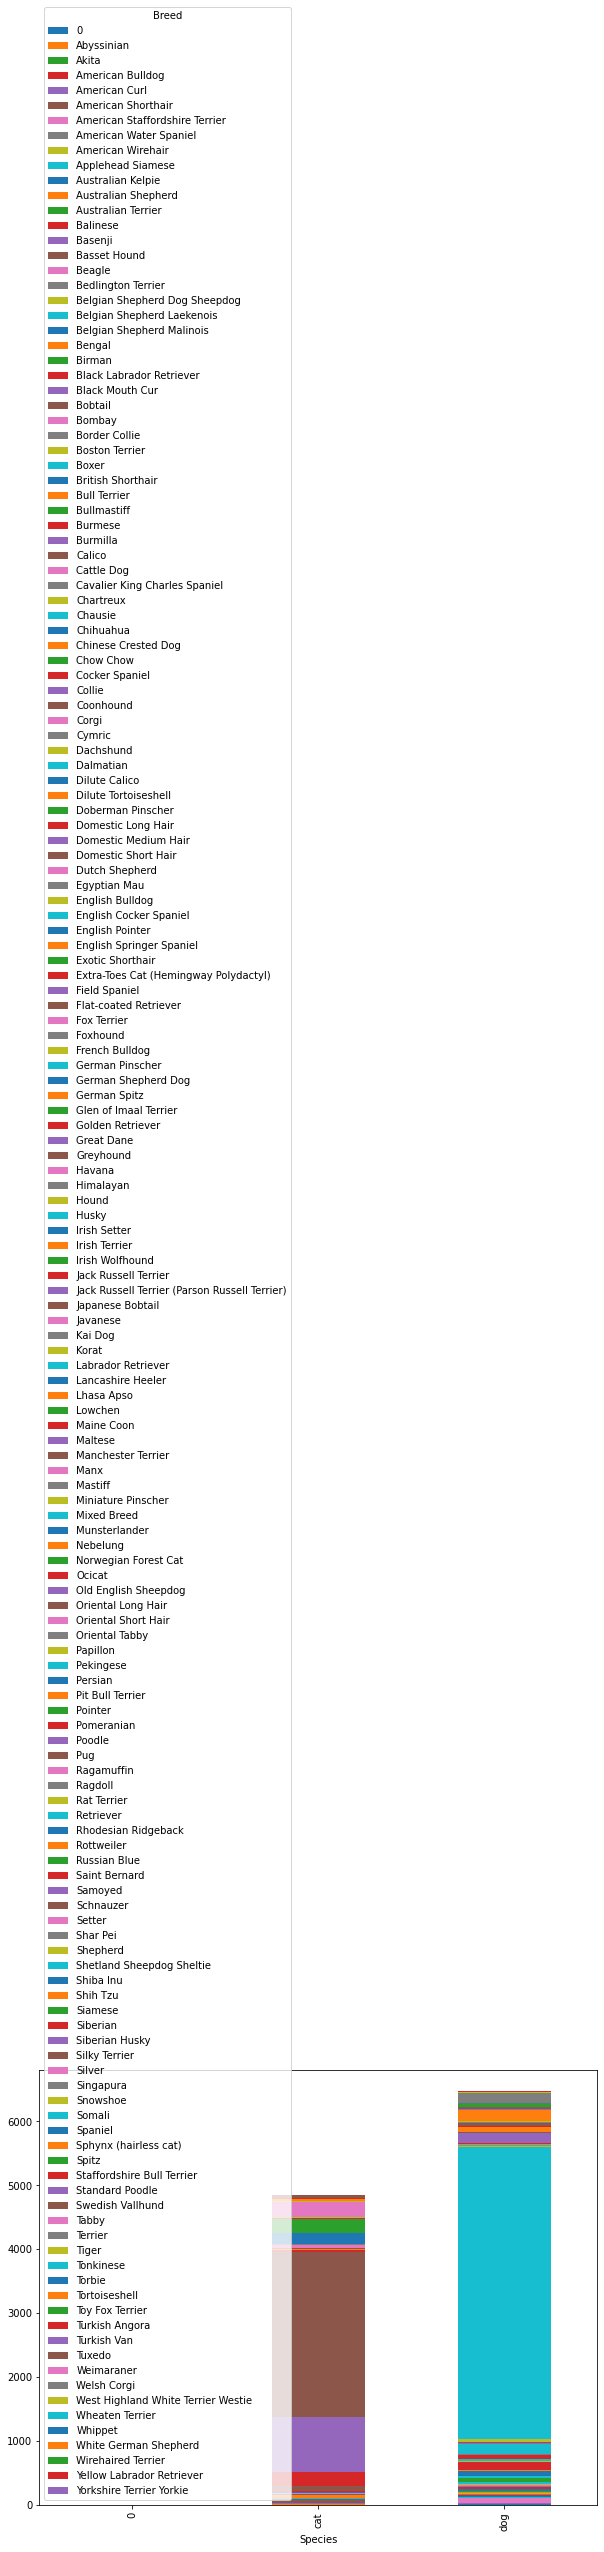

In [14]:
df.groupby(['Species', 'Breed']).count()['PetID'].unstack().plot(kind='bar', stacked=True, figsize=(10, 8))

<AxesSubplot:xlabel='Breed'>

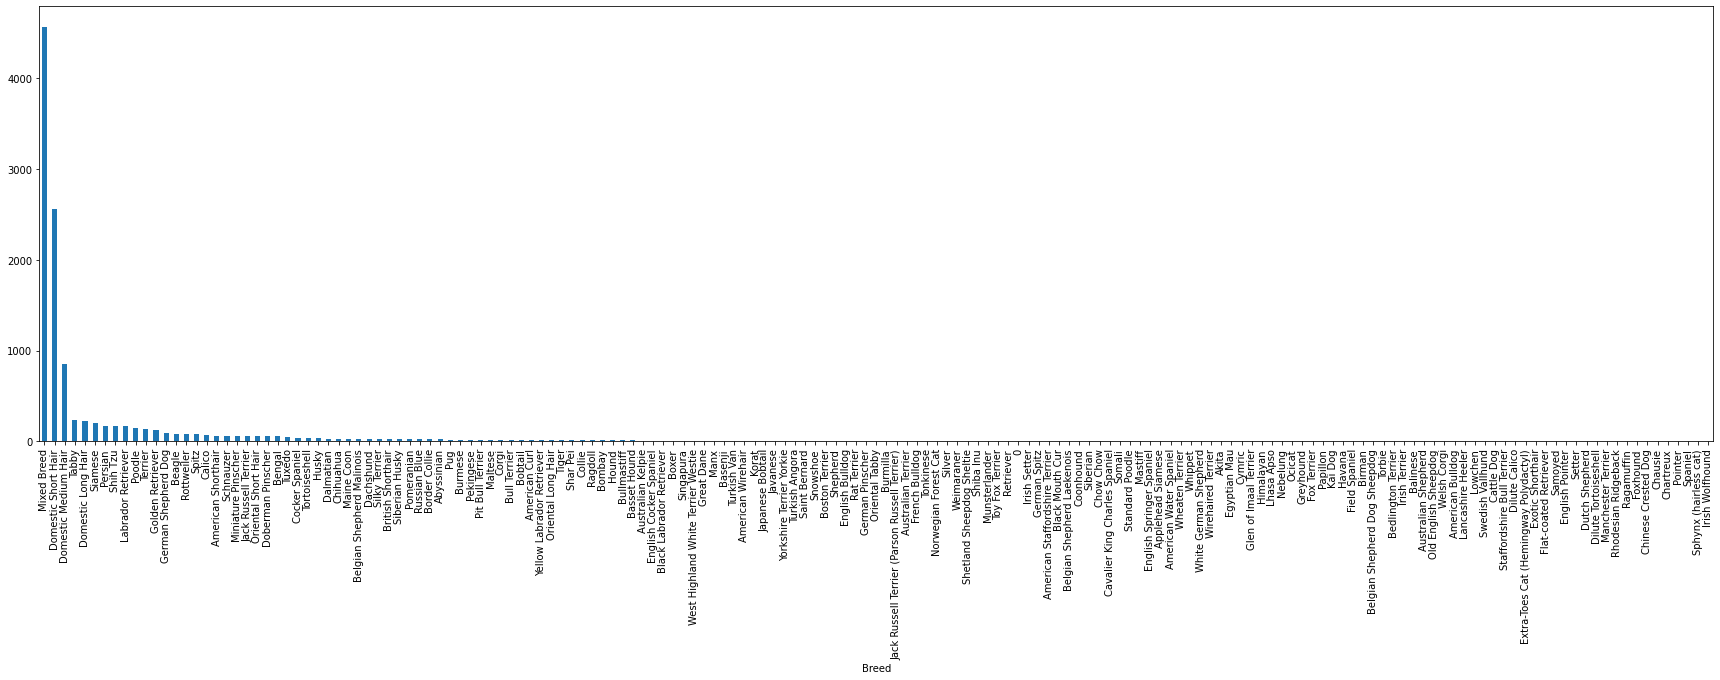

In [18]:
#plot the distribution of the number of entries per breed
df.groupby(['Breed']).count()['PetID'].sort_values(ascending=False).plot(kind='bar', figsize=(30, 8))

With our data ready, let's begin preparing our dataset.

In [4]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = pathlib.Path('./train')

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28410 files belonging to 2 classes.
Using 22728 files for training.


In [7]:
test_dir = pathlib.Path('./train')
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28410 files belonging to 2 classes.
Using 5682 files for validation.


In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.054901965 1.0


In [13]:
class_names = train_ds.class_names
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [18]:
#Hello
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
711/711 [==============================] - 461s 646ms/step - loss: 0.6317 - accuracy: 0.6457 - val_loss: 0.5894 - val_accuracy: 0.6892
Epoch 2/10
711/711 [==============================] - 435s 611ms/step - loss: 0.5514 - accuracy: 0.7185 - val_loss: 0.5588 - val_accuracy: 0.7117
Epoch 3/10
711/711 [==============================] - 441s 620ms/step - loss: 0.4820 - accuracy: 0.7682 - val_loss: 0.5315 - val_accuracy: 0.7357
Epoch 4/10
711/711 [==============================] - 445s 626ms/step - loss: 0.3974 - accuracy: 0.8163 - val_loss: 0.5758 - val_accuracy: 0.7357
Epoch 5/10
711/711 [==============================] - 449s 631ms/step - loss: 0.2955 - accuracy: 0.8710 - val_loss: 0.6161 - val_accuracy: 0.7469
Epoch 6/10
711/711 [==============================] - 454s 638ms/step - loss: 0.1957 - accuracy: 0.9201 - val_loss: 0.7648 - val_accuracy: 0.7314
Epoch 7/10
711/711 [==============================] - 461s 648ms/step - loss: 0.1249 - accuracy: 0.9531 - val_loss: 0.9144 -

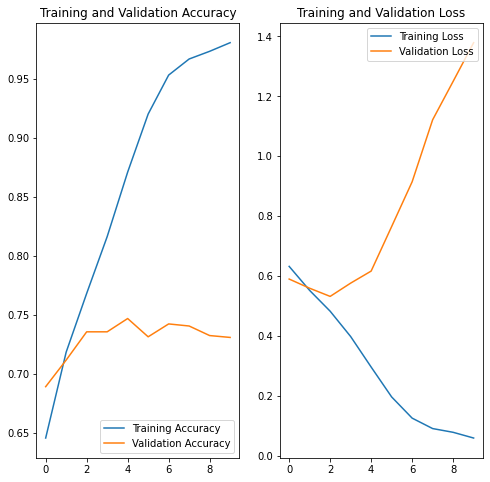

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [29]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [32]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
711/711 [==============================] - 478s 670ms/step - loss: 0.6431 - accuracy: 0.6304 - val_loss: 0.6526 - val_accuracy: 0.6264
Epoch 2/15
711/711 [==============================] - 485s 682ms/step - loss: 0.5936 - accuracy: 0.6829 - val_loss: 0.5725 - val_accuracy: 0.6969
Epoch 3/15
711/711 [==============================] - 491s 691ms/step - loss: 0.5697 - accuracy: 0.7019 - val_loss: 0.5592 - val_accuracy: 0.7080
Epoch 4/15
711/711 [==============================] - 494s 695ms/step - loss: 0.5529 - accuracy: 0.7185 - val_loss: 0.5459 - val_accuracy: 0.7203
Epoch 5/15
711/711 [==============================] - 497s 698ms/step - loss: 0.5378 - accuracy: 0.7301 - val_loss: 0.5406 - val_accuracy: 0.7244
Epoch 6/15
711/711 [==============================] - 500s 703ms/step - loss: 0.5264 - accuracy: 0.7364 - val_loss: 0.5210 - val_accuracy: 0.7358
Epoch 7/15
711/711 [==============================] - 509s 716ms/step - loss: 0.5104 - accuracy: 0.7491 - val_loss: 0.5180 -

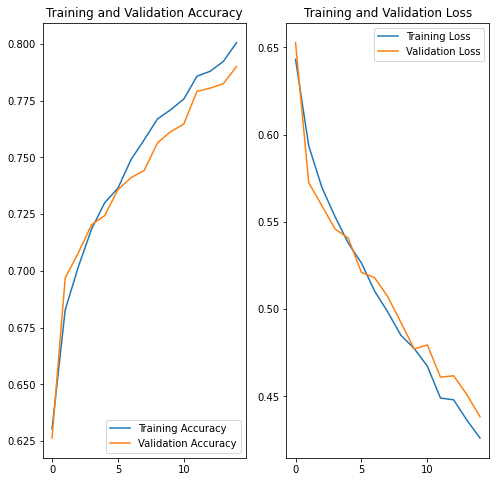

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [94]:
import random
test_images_path = './test_images'

data_dir = pathlib.Path('test_images/fe42c1ee7-3.jpg')
display_image = PIL.Image.open(str(data_dir))
display_image.show()

img = tf.keras.utils.load_img(
    data_dir, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 33ms/step
This image most likely belongs to dogs with a 63.71 percent confidence.



(viewnior:20129): Gtk-WARNING **: 15:37:30.324: Unable to locate theme engine in module_path: "murrine",

(viewnior:20129): Gtk-WARNING **: 15:37:30.325: Unable to locate theme engine in module_path: "murrine",

(viewnior:20129): Gtk-WARNING **: 15:37:30.325: Unable to locate theme engine in module_path: "murrine",

(viewnior:20129): Gtk-WARNING **: 15:37:30.326: Unable to locate theme engine in module_path: "murrine",

(viewnior:20129): Gtk-WARNING **: 15:37:30.326: Unable to locate theme engine in module_path: "murrine",

(viewnior:20129): Gtk-WARNING **: 15:37:30.326: Unable to locate theme engine in module_path: "murrine",

(viewnior:20129): Gtk-WARNING **: 15:37:30.327: Unable to locate theme engine in module_path: "murrine",
